# Twitter Sentiment Analysis Dataset

### Overview

### This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity.  
### There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

In [86]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# data cleaning
import re, string
import demoji

# transformers
import transformers
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

from imblearn.over_sampling import RandomOverSampler

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import itertools


sns.set_style("darkgrid")

In [2]:
# read Train CSV, set new Column Names and drop unimportant columns
df_train = pd.read_csv("twitter_training.csv")
df_train.columns = ["Id", "Name", "Target", "Text"]
df_train.drop(columns=["Id", "Name"], axis=1, inplace=True)
df_train.head()

,Target,Text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [3]:
# read Validation CSV, set new Column Names and drop unimportant columns
df_val = pd.read_csv("twitter_validation.csv")
df_val.columns = ["Id", "Name", "Target", "Text"]
df_val.drop(columns=["Id", "Name"], axis=1, inplace=True)
df_val.head()

,Target,Text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [4]:
# Show how much Rows we have
print(f"Len Train DataFrame: {len(df_train)}")
print(f"Len Validation DataFrame: {len(df_val)}")

Len Train DataFrame: 74681
Len Validation DataFrame: 999


In [5]:
# drop duplicates
df_train = df_train.drop_duplicates()
df_val = df_val.drop_duplicates()
print(f"Len Train DataFrame: {len(df_train)}")
print(f"Len Validation DataFrame: {len(df_val)}")

Len Train DataFrame: 69772
Len Validation DataFrame: 998


In [6]:
# check for NaN Values in DataFrames
check_nan_train = df_train.isnull().values.any()
check_nan_val = df_val.isnull().values.any()
print(f"NaN Values in Train DataFrame? {check_nan_train}")
print(f"NaN Values in Validation DataFrame? {check_nan_val}")

NaN Values in Train DataFrame? True
NaN Values in Validation DataFrame? False


In [7]:
# Drop Rows with NaN Value
df_train = df_train.dropna()

# Check again and check the new Length from Train DataFrame
check_nan_train = df_train.isnull().values.any()
print(f"NaN Values in Train DataFrame? {check_nan_train}\n\n")

print(f"Len Train DataFrame: {len(df_train)}")
print(f"Len Validation DataFrame: {len(df_val)}")

NaN Values in Train DataFrame? False


Len Train DataFrame: 69768
Len Validation DataFrame: 998


In [8]:
# shuffle Train DataFrame
df_train = df_train.sample(frac=1, random_state=42)
df_train.head()

,Target,Text
39301,Negative,@ PlayHearthstone On the mobile version I only...
19663,Irrelevant,"Happy birthday, my # 1 extension!"
5161,Negative,So apparently Fred Perry takes off the Proud B...
38735,Irrelevant,@christineexists my bestie @hearthstone_d and ...
20387,Positive,Important research and so fascinating! .


In [9]:
import random

# print some examples
for i in range(4):
    random_idx = random.choice(df_train.index)  # get random index
    # get values from random_idx
    values = df_train.loc[random_idx, ["Target", "Text"]].tolist()
    print(f"Target: {values[0]}\nText:\n{values[1]}\n\n")

Target: Negative
Text:
They took my phone number from me. Thanks @verizon I was rey pay the bill yall r jus give me enough time tho


Target: Positive
Text:
to play Borderlands 2 again because I hate myself, glad I installed it, it works perfectly on my 8 year old Mac, just nice


Target: Negative
Text:
@ NBA2K @ Ronnie2K Not sure if I feel discriminated against, why would you ask if I communicate with anyone on 2K? Do you know that there are deaf people who play 2K and it is difficult for us to use a microphone?. We can only show how well we play the game, but... communicate? C'mon!


Target: Negative
Text:
Wtf lol




In [10]:
# CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS


def remove_emojis(text: str) -> str:
    """
    Removes emojis from the input text using the `demoji` library.

    Args:
        text (str): The input text from the emojis needs to be removed.

    Returns:
        str: The input text with all emojis removed.
    """
    return demoji.replace(text, "")


def strip_all_entities(text: str) -> str:
    """
    Cleans the input text by removing new line characters, converting to lowercase,
    and stripping out URLs, mentions, non-ASCII characters, and certain punctuation marks.

    Args:
        text (str): The input text to be cleaned.

    Returns:
        str: The cleaned text, with specified characters and patterns removed.
    """
    text = text.replace("\r", "").replace("\n", " ").replace("\n", " ").lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r"[^\x00-\x7f]", r"", text)
    banned_list = string.punctuation + "Ã" + "±" + "ã" + "¼" + "â" + "»" + "§"
    table = str.maketrans("", "", banned_list)
    text = text.translate(table)
    return text


def clean_hashtags(tweet: str) -> str:
    """
    Processes hashtags in a tweet by removing hashtags at the end of the tweet and stripping the hashtag symbol from those in the middle.

    Args:
        tweet (str): The tweet text to be processed.

    Returns:
    str: The modified tweet text, where middle-positioned hashtags have been converted into plain words by removing the '#' symbol,
         and any hashtags at the tweet's end have been deleted.
    """
    new_tweet = " ".join(
        word.strip()
        for word in re.split("#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)", tweet)
    )
    new_tweet2 = " ".join(word.strip() for word in re.split("#|_", new_tweet))
    return new_tweet2


def filter_chars(a: str) -> str:
    """
    Filters out words containing special characters such as '&' and '$' from the input string.

    Args:
        a (str): The input string from which words containing '&' and '$' should be removed.

    Returns:
        str: The cleaned string with words containing the specified special characters removed.
    """
    sent = []
    for word in a.split(" "):
        if ("$" in word) | ("&" in word):
            sent.append("")
        else:
            sent.append(word)
    return " ".join(sent)


def remove_mult_spaces(text: str) -> str:
    """
    Reduces multiple consecutive spaces in the input text to a single space.

    Args:
        text (str): The input text with potentially multiple consecutive spaces.

    Returns:
        str: The input text with all multiple spaces reduced to single spaces.
    """
    return re.sub("\s\s+", " ", text)

In [11]:
# create clean training texts
texts_clean = []
for t in df_train["Text"].values:
    texts_clean.append(
        remove_mult_spaces(
            filter_chars(clean_hashtags(strip_all_entities(remove_emojis(t))))
        )
    )

In [12]:
# create clean validation texts
texts_clean_val = []
for t in df_val["Text"].values:
    texts_clean_val.append(
        remove_mult_spaces(
            filter_chars(clean_hashtags(strip_all_entities(remove_emojis(t))))
        )
    )

In [13]:
# make a new Column to the DataFrames
df_train["TextClean"] = texts_clean
df_val["TextClean"] = texts_clean_val
df_train.head()

,Target,Text,TextClean
39301,Negative,@ PlayHearthstone On the mobile version I only...,playhearthstone on the mobile version i only g...
19663,Irrelevant,"Happy birthday, my # 1 extension!",happy birthday my 1 extension
5161,Negative,So apparently Fred Perry takes off the Proud B...,so apparently fred perry takes off the proud b...
38735,Irrelevant,@christineexists my bestie @hearthstone_d and ...,my bestie and i are reading the devouring grey...
20387,Positive,Important research and so fascinating! .,important research and so fascinating


In [14]:
# get the text lengths from Train DataFrame
text_len = []
for text in df_train["TextClean"].values:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [15]:
# get the text lengths from Test DataFrame
text_len_val = []
for text in df_val["TextClean"].values:
    tweet_len_val = len(text.split())
    text_len_val.append(tweet_len)

In [16]:
# make a new Column to the DataFrames
df_train["TextLen"] = text_len
df_val["TextLen"] = text_len_val
df_train.head()

,Target,Text,TextClean,TextLen
39301,Negative,@ PlayHearthstone On the mobile version I only...,playhearthstone on the mobile version i only g...,53
19663,Irrelevant,"Happy birthday, my # 1 extension!",happy birthday my 1 extension,5
5161,Negative,So apparently Fred Perry takes off the Proud B...,so apparently fred perry takes off the proud b...,20
38735,Irrelevant,@christineexists my bestie @hearthstone_d and ...,my bestie and i are reading the devouring grey...,36
20387,Positive,Important research and so fascinating! .,important research and so fascinating,5


In [17]:
# get training tweets with less than 4 words
data_less_10_words = df_train[df_train["TextLen"] < 4]
print(
    f"Len Original Dataframe: {len(df_train)}\nLen DataFrame with Less 4 Words: {len(data_less_10_words)}"
)
data_less_10_words.head()

Len Original Dataframe: 69768
Len DataFrame with Less 4 Words: 5015


,Target,Text,TextClean,TextLen
7013,Neutral,I'm WHEEZING,im wheezing,2
56075,Neutral,TKers smh,tkers smh,2
69279,Positive,I wow,i wow,2
18419,Positive,let’s gooooo 🤩,lets gooooo,2
1266,Positive,Love him.,love him,2


In [18]:
# get validation tweets with less than 4 words
data_less_10_words_val = df_val[df_val["TextLen"] < 4]
print(
    f"Len Original Dataframe: {len(df_val)}\nLen DataFrame with Less 4 Words: {len(data_less_10_words_val)}"
)
data_less_10_words_val.head()

Len Original Dataframe: 998
Len DataFrame with Less 4 Words: 0


,Target,Text,TextClean,TextLen


In [19]:
# new train DataFrame with Tweets more than 4 words
df_train = df_train[df_train["TextLen"] > 4]
print(f"Len Cleaner Train DataFrame: {len(df_train)}")

Len Cleaner Train DataFrame: 62340


In [20]:
df_train.head()

,Target,Text,TextClean,TextLen
39301,Negative,@ PlayHearthstone On the mobile version I only...,playhearthstone on the mobile version i only g...,53
19663,Irrelevant,"Happy birthday, my # 1 extension!",happy birthday my 1 extension,5
5161,Negative,So apparently Fred Perry takes off the Proud B...,so apparently fred perry takes off the proud b...,20
38735,Irrelevant,@christineexists my bestie @hearthstone_d and ...,my bestie and i are reading the devouring grey...,36
20387,Positive,Important research and so fascinating! .,important research and so fascinating,5


In [21]:
# Roberta Tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

In [22]:
# get Token Lengths from Training Tweets
token_lens = []

for text in df_train["TextClean"].values:
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    token_lens.append(len(tokens))

print(f"Max Token Len: {np.max(token_lens)}")
print(f"Mean Tokens Len: {np.mean(token_lens)}")

Max Token Len: 200
Mean Tokens Len: 27.266971446904073


In [23]:
# sort Token Lens (most tokens at head)
df_train["TokenLen"] = token_lens
df_train = df_train.sort_values(by="TokenLen", ascending=False)
df_train.head(30)

,Target,Text,TextClean,TextLen,TokenLen
43849,Irrelevant,It's the birthday of toga gggggggggggggggggggg...,its the birthday of toga ggggggggggggggggggggg...,6,200
18127,Positive,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,200
10255,Neutral,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,200
3967,Irrelevant,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,200
3097,Negative,"Italy, Italy, Italy, Italy, Italy, Italy, Ital...",italy italy italy italy italy italy italy ital...,99,200
28993,Negative,"At the same time, there are many low-income co...",at the same time there are many lowincome coun...,106,196
8545,Positive,I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA S...,i really have the overwatch rn game sea sea se...,166,170
42463,Irrelevant,PUBG: Purple Invincible Babaaa aa aa aa aa aa ...,pubg purple invincible babaaa aa aa aa aa aa a...,84,168
70939,Neutral,The event dedicated to Victory Day in the Grea...,the event dedicated to victory day in the grea...,150,154
39409,Neutral,KUZ YU VENT PUO. LOCK PHART FANG FANG FANG FAN...,kuz yu vent puo lock phart fang fang fang fang...,67,133


In [24]:
# new DataFrame without top 15 Rows (balancing between token lengths)
df_train = df_train.iloc[15:]
df_train.head()

,Target,Text,TextClean,TextLen,TokenLen
30349,Irrelevant,Yassuo scores Perfect Example of High Level Tr...,yassuo scores perfect example of high level tr...,72,100
60819,Irrelevant,Leaked out FIFA FIFA 21 GTA 6 gameplay. open t...,leaked out fifa fifa 21 gta 6 gameplay open th...,57,100
50511,Negative,she Leaked FIFA 21 GTA 6 gameplay. open the li...,she leaked fifa 21 gta 6 gameplay open the lin...,57,99
73041,Neutral,Amazing good deal for you!.. Acer 6 Nitro 5 Ya...,amazing good deal for you acer 6 nitro 5 yamah...,60,92
34767,Positive,@AppStore plz unban fortnite I always love app...,plz unban fortnite i always love apple product...,68,91


In [25]:
# get Token Lengths from Validation Tweets
tokens_lens_val = []

for text in df_val["TextClean"]:
    tokens = tokenizer.encode(text, max_length=512, truncation=True)
    tokens_lens_val.append(len(tokens))

print(f"Max Token Len: {np.max(tokens_lens_val)}")
print(f"Mean Tokens Len: {np.mean(tokens_lens_val)}")

Max Token Len: 87
Mean Tokens Len: 29.18436873747495


In [26]:
# sort Token Lens (most tokens at head)
df_val["TokenLen"] = tokens_lens_val
df_val = df_val.sort_values(by="TokenLen", ascending=False)
df_val.head()

,Target,Text,TextClean,TextLen,TokenLen
462,Irrelevant,Leaked FIFA 21 GTA 6 gameplay\nopen the link f...,leaked fifa 21 gta 6 gameplay open the link fo...,9,87
481,Positive,Nice to bow you\n\nThis my Creepypasta/Assassi...,nice to bow you this my creepypastaassassins c...,9,79
299,Irrelevant,HOW TO IMPRESS INDIAN GIRL\nsahilyaduvanshi.in...,how to impress indian girl sahilyaduvanshiinlo...,9,78
169,Positive,Watching You Kalloori Perfect Situation Mystic...,watching you kalloori perfect situation mystic...,9,77
230,Irrelevant,We are pleased to announce the names of the re...,we are pleased to announce the names of the re...,9,75


In [27]:
# new DataFrame without top 1 Row (balancing between tweets lengths)
df_val = df_val.iloc[1:]
df_val.head()

,Target,Text,TextClean,TextLen,TokenLen
481,Positive,Nice to bow you\n\nThis my Creepypasta/Assassi...,nice to bow you this my creepypastaassassins c...,9,79
299,Irrelevant,HOW TO IMPRESS INDIAN GIRL\nsahilyaduvanshi.in...,how to impress indian girl sahilyaduvanshiinlo...,9,78
169,Positive,Watching You Kalloori Perfect Situation Mystic...,watching you kalloori perfect situation mystic...,9,77
230,Irrelevant,We are pleased to announce the names of the re...,we are pleased to announce the names of the re...,9,75
518,Neutral,Dart Against Humanity Ep. 79 (S5 E4): The New ...,dart against humanity ep 79 s5 e4 the new not ...,9,74


In [28]:
# Make Target Column Numeric in Training DataFrame (Irrelevant == Neutral)
df_train["Target"] = df_train["Target"].map(
    {"Negative": 0, "Neutral": 1, "Irrelevant": 1, "Positive": 2}
)
df_train["Target"].value_counts()

Target
1    26842
0    18985
2    16498
Name: count, dtype: int64

In [29]:
# Make Target Column Numeric in Validation DataFrame (Irrelevant == Neutral)
df_val["Target"] = df_val["Target"].map(
    {"Negative": 0, "Neutral": 1, "Irrelevant": 1, "Positive": 2}
)
df_val["Target"].value_counts()

Target
1    455
2    276
0    266
Name: count, dtype: int64

In [30]:
# helper function for plotting value counts
def plot_value_counts(df: pd.DataFrame, title: str) -> None:
    """
    Generates a bar plot for the distribution of values in the 'Target' column of a DataFrame. 

    Args:
        df (pd.DataFrame): The DataFrame containing the 'Target' column whose value distribution is to be plotted.
        title (str): The title for the plot, providing context or description about the plot.

    Returns:
        None: This function does not return anything. It displays the generated plot directly.
    """
    df["Target"].value_counts().plot(
        kind="bar",
        figsize=(10, 5),
        title=title,
        ylabel="Values",
        xlabel="Targets [0: Negative, 1: Neutral, 2: Positive]",
    )
    plt.show()

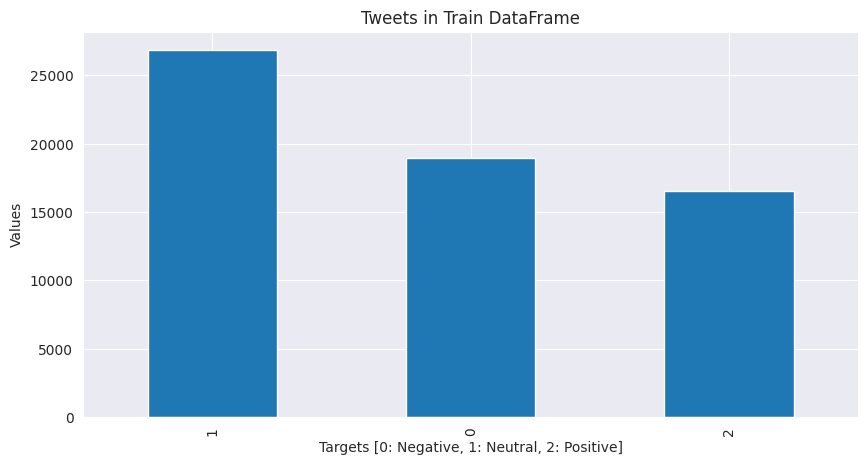

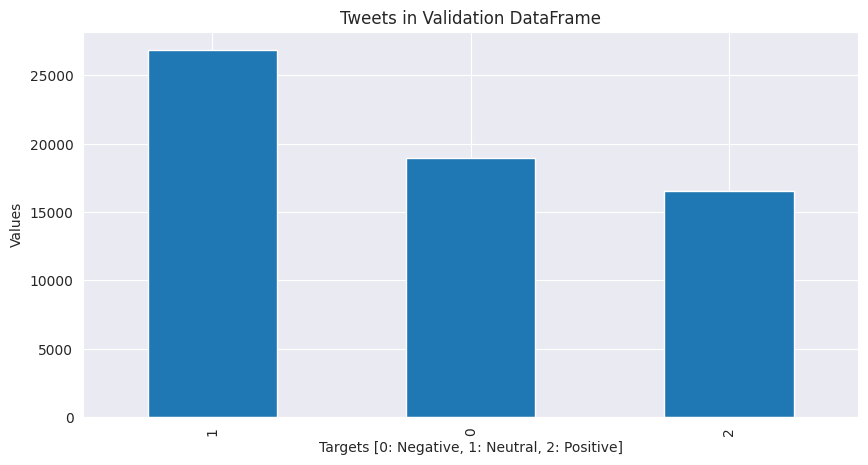

In [31]:
plot_value_counts(df=df_train, title="Tweets in Train DataFrame")
plot_value_counts(df=df_train, title="Tweets in Validation DataFrame")

In [32]:
# Balance the Tweets with RandomOverSampler (create Copies)
ros = RandomOverSampler()

x_clean_text = np.array(df_train["TextClean"]).reshape(-1, 1)
y_target = np.array(df_train["Target"]).reshape(-1, 1)

text_train, target_train = ros.fit_resample(x_clean_text, y_target)

In [33]:
train_data = list(zip([x[0] for x in text_train], target_train))

# create balanced Training DataFrame
balanced_df = pd.DataFrame(train_data, columns=["TextClean", "Target"])
print(f"Len Balanced DataFrame: {len(balanced_df)}\n")
balanced_df["Target"].value_counts()

Len Balanced DataFrame: 80526



Target
1    26842
0    26842
2    26842
Name: count, dtype: int64

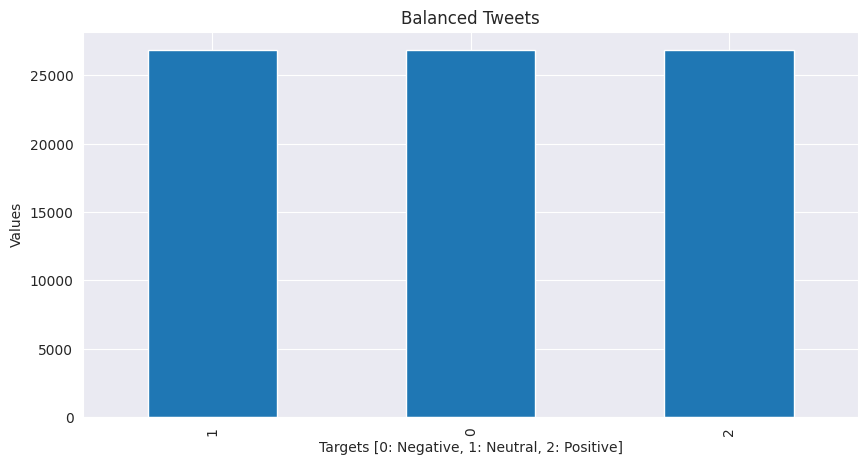

In [34]:
plot_value_counts(df=balanced_df, title="Balanced Tweets")

In [35]:
balanced_df.head()

,TextClean,Target
0,yassuo scores perfect example of high level tr...,1
1,leaked out fifa fifa 21 gta 6 gameplay open th...,1
2,she leaked fifa 21 gta 6 gameplay open the lin...,0
3,amazing good deal for you acer 6 nitro 5 yamah...,1
4,plz unban fortnite i always love apple product...,2


In [36]:
df_val.head()

,Target,Text,TextClean,TextLen,TokenLen
481,2,Nice to bow you\n\nThis my Creepypasta/Assassi...,nice to bow you this my creepypastaassassins c...,9,79
299,1,HOW TO IMPRESS INDIAN GIRL\nsahilyaduvanshi.in...,how to impress indian girl sahilyaduvanshiinlo...,9,78
169,2,Watching You Kalloori Perfect Situation Mystic...,watching you kalloori perfect situation mystic...,9,77
230,1,We are pleased to announce the names of the re...,we are pleased to announce the names of the re...,9,75
518,1,Dart Against Humanity Ep. 79 (S5 E4): The New ...,dart against humanity ep 79 s5 e4 the new not ...,9,74


In [37]:
# Training und Validation Data
X_train = balanced_df["TextClean"].values
y_train = balanced_df["Target"].values

X_val = df_val["TextClean"].values
y_val = df_val["Target"].values

In [38]:
# One Hot Encode the Labels
ohe = OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()

In [39]:
print(f"Length Train: {len(X_train)}\nLength Validation: {len(X_val)}")

y_train[:10]

Length Train: 80526
Length Validation: 997


array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [40]:
df_train.head()

,Target,Text,TextClean,TextLen,TokenLen
30349,1,Yassuo scores Perfect Example of High Level Tr...,yassuo scores perfect example of high level tr...,72,100
60819,1,Leaked out FIFA FIFA 21 GTA 6 gameplay. open t...,leaked out fifa fifa 21 gta 6 gameplay open th...,57,100
50511,0,she Leaked FIFA 21 GTA 6 gameplay. open the li...,she leaked fifa 21 gta 6 gameplay open the lin...,57,99
73041,1,Amazing good deal for you!.. Acer 6 Nitro 5 Ya...,amazing good deal for you acer 6 nitro 5 yamah...,60,92
34767,2,@AppStore plz unban fortnite I always love app...,plz unban fortnite i always love apple product...,68,91


In [41]:
# Max Len for Tokenizing (max length is 100 Tokens but 128 is a better setting)
MAX_LEN = 128

# Roberta Tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")


def tokenize(data: list[str], max_len: int = MAX_LEN) -> tuple[np.ndarray, np.ndarray]:
    """
    Tokenizes a list of text strings into input IDs and attention masks suitable for input into pre-trained models. 

    Args:
        data (list[str]): A list of text strings to be tokenized. Each text string in this list represents one piece of input data.
        max_len (int, optional): The maximum length of the tokenized sequences. 
                                If a sequence is shorter than this length, it will be padded up to `max_len`. 
                                If it is longer, it will be truncated to this length. 

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing two elements:
            - The first element is a NumPy array of input IDs. 
              Each row in the array corresponds to the tokenized version of the corresponding text string in the input data.
            - The second element is a NumPy array of attention masks. 
              Each row in the array is an attention mask corresponding to the tokenized version of the corresponding text string in the input data. 
              It has 1s for real tokens and 0s for padding tokens.

    Note:
        This function assumes that a pre-trained tokenizer is available and has been instantiated as `tokenizer`.
    """
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding="max_length",
            return_attention_mask=True,
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])
    return np.array(input_ids), np.array(attention_masks)

In [42]:
# get model inputs
train_input_ids, train_attention_masks = tokenize(data=X_train)
val_input_ids, val_attention_masks = tokenize(data=X_val)

In [43]:
def create_model(roberta_model: transformers.PreTrainedModel, max_len: int = MAX_LEN) -> tf.keras.Model:
    """
    Initializes and compiles a TensorFlow model with a pre-trained RoBERTa model from the Hugging Face's Transformers library. 
    This model is designed for a multi-class classification task, taking sequences of input IDs and attention masks, 
    processing them through the RoBERTa model, and outputting class probabilities through a final dense layer.

    Args:
        roberta_model (transformers.PreTrainedModel): The pre-trained RoBERTa model
        max_len (int, optional): The maximum sequence length for model inputs. Input sequences will be padded or truncated to this length. 

    Returns:
        tf.keras.Model: A compiled Keras model ready for training.
    """
    # model metrics  
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # input layers
    input_ids = tf.keras.Input(shape=(max_len,), dtype="int32")
    attention_masks = tf.keras.Input(shape=(max_len,), dtype="int32")
    
    # roberta model
    output = roberta_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    
    # create and compile model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [95]:
# pretrained Roberta Model
roberta_model = TFRobertaModel.from_pretrained("roberta-base")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [45]:
# create model
model = create_model(roberta_model=roberta_model)
# we dont freeze the backbone
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_1[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [46]:
checkpoint_path = "./roberta_model/"
tensb_logs = "./logs/"

# save the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=0, save_best_only=True
)

# tensorboard callback
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=tensb_logs, update_freq="epoch")

In [48]:
callbacks = [model_checkpoint, tensorboard]
# train model
history = model.fit(
    [train_input_ids, train_attention_masks],
    y_train,
    validation_data=([val_input_ids, val_attention_masks], y_val),
    epochs=5,
    batch_size=32,
    callbacks=callbacks,
)

Epoch 1/5
2517/2517 [==============================] - ETA: 0s - loss: 0.6283 - categorical_accuracy: 0.7335INFO:tensorflow:Assets written to: ./roberta_model/assets


INFO:tensorflow:Assets written to: ./roberta_model/assets


2517/2517 [==============================] - 739s 294ms/step - loss: 0.6283 - categorical_accuracy: 0.7335 - val_loss: 0.3485 - val_categorical_accuracy: 0.8726
Epoch 2/5
2517/2517 [==============================] - ETA: 0s - loss: 0.3053 - categorical_accuracy: 0.8843INFO:tensorflow:Assets written to: ./roberta_model/assets


INFO:tensorflow:Assets written to: ./roberta_model/assets


2517/2517 [==============================] - 735s 292ms/step - loss: 0.3053 - categorical_accuracy: 0.8843 - val_loss: 0.1969 - val_categorical_accuracy: 0.9438
Epoch 3/5
2517/2517 [==============================] - ETA: 0s - loss: 0.1442 - categorical_accuracy: 0.9489INFO:tensorflow:Assets written to: ./roberta_model/assets


INFO:tensorflow:Assets written to: ./roberta_model/assets


2517/2517 [==============================] - 731s 290ms/step - loss: 0.1442 - categorical_accuracy: 0.9489 - val_loss: 0.1915 - val_categorical_accuracy: 0.9529
Epoch 4/5
2517/2517 [==============================] - ETA: 0s - loss: 0.0856 - categorical_accuracy: 0.9698INFO:tensorflow:Assets written to: ./roberta_model/assets


INFO:tensorflow:Assets written to: ./roberta_model/assets


2517/2517 [==============================] - 729s 290ms/step - loss: 0.0856 - categorical_accuracy: 0.9698 - val_loss: 0.1782 - val_categorical_accuracy: 0.9599
Epoch 5/5
2517/2517 [==============================] - 710s 282ms/step - loss: 0.0587 - categorical_accuracy: 0.9801 - val_loss: 0.2115 - val_categorical_accuracy: 0.9569


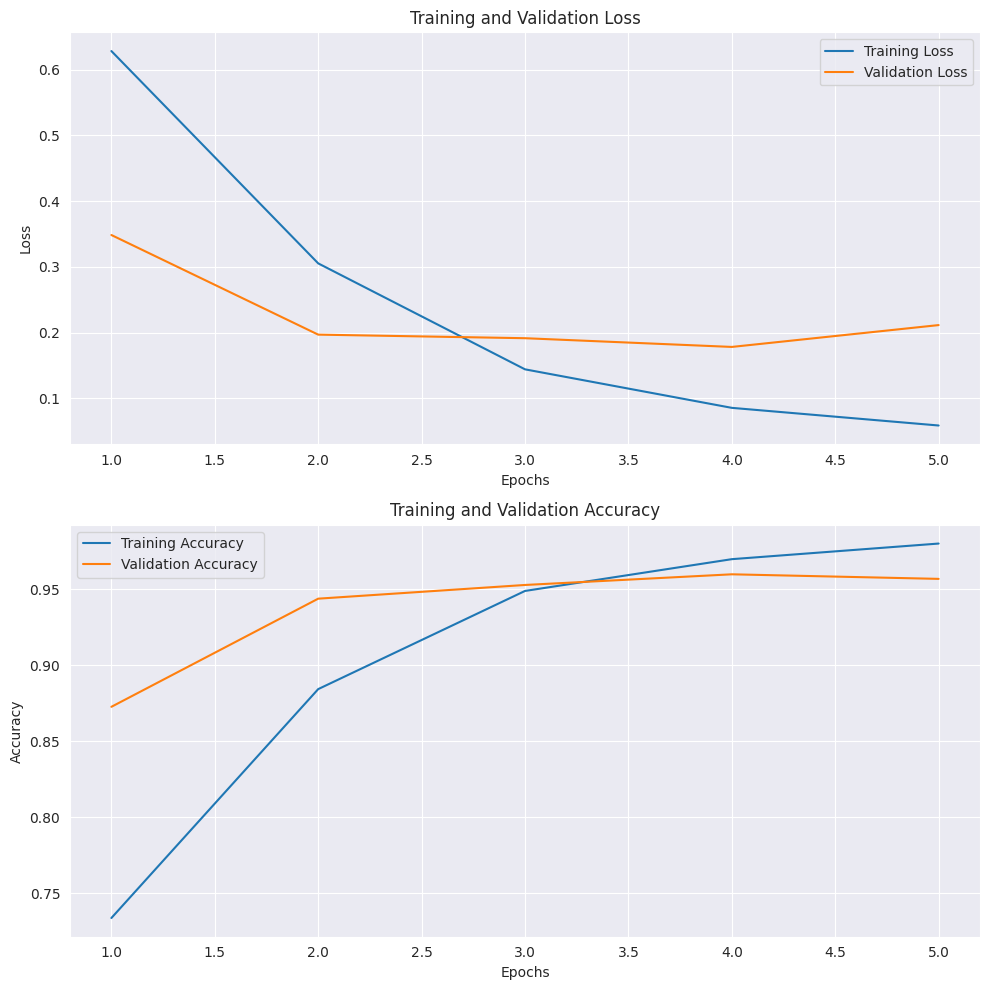

In [50]:
# define history metrics
loss = history.history["loss"]
val_loss = history.history["val_loss"]
accuracy = history.history["categorical_accuracy"]
val_accuracy = history.history["val_categorical_accuracy"]

# the epochs the model trained
epochs = range(1, len(loss) + 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# plot training loss and validation loss
ax[0].plot(epochs, loss, label="Training Loss")
ax[0].plot(epochs, val_loss, label="Validation Loss")
ax[0].set_title("Training and Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

# plot training accuracy and validation accuracy
ax[1].plot(epochs, accuracy, label="Training Accuracy")
ax[1].plot(epochs, val_accuracy, label="Validation Accuracy")
ax[1].set_title("Training and Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()

In [59]:
# get predicted probabilities
y_probs = model.predict([val_input_ids, val_attention_masks])

32/32 [==============================] - 5s 108ms/step


In [62]:
# get predicted labels
y_pred = np.argmax(y_probs, axis=1)
y_pred[:10]

array([2, 1, 2, 1, 1, 1, 1, 1, 1, 1])

In [65]:
# get true labels
y_true = np.argmax(y_val, axis=1)
y_true[:10]

array([2, 1, 2, 1, 1, 1, 1, 1, 1, 1])

In [63]:
def make_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    classes: np.ndarray = None,
    figsize: tuple[int, int] = (10, 10),
    text_size: int = 15,
    cmap: str = "Blues",
    norm: bool = False,
    savefig: bool = False,
) -> None:
    """
    Makes a labelled confusion matrix comparing predictions and ground truth labels, with options to normalize
    and save the figure.

    Args:
      y_true (np.ndarray): Array of truth labels (must be same shape as y_pred).
      y_pred (np.ndarray): Array of predicted labels (must be same shape as y_true).
      classes (np.ndarray): Array of class labels (e.g., string form). If `None`, integer labels are used.
      figsize (tuple[int, int]): Size of output figure (default=(10, 10)).
      text_size (int): Size of output figure text (default=15).
      norm (bool): If True, normalize the values in the confusion matrix (default=False).
      savefig (bool): If True, save the confusion matrix plot to the current working directory (default=False).

    Returns:
        None: This function does not return a value but displays a Confusion Matrix. Optionally, it saves the plot.

    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10,
                            norm=True,
                            savefig=True)
    """
    # Create the confusion matrix
    cm = (
        confusion_matrix(y_true, y_pred, normalize="true")
        if norm
        else confusion_matrix(y_true, y_pred)
    )

    # Plot the figure
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=cmap)
    fig.colorbar(cax)

    # Set class labels
    if classes is not None:
        labels = classes
    else:
        labels = np.arange(len(cm))

    # Set the labels and titles
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(len(labels)),
        yticks=np.arange(len(labels)),
        xticklabels=labels,
        yticklabels=labels,
    )
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Annotate the cells with the appropriate values
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            f"{cm[i, j]:.2f}" if norm else f"{cm[i, j]}",
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black",
            size=text_size,
        )

    plt.tight_layout()
    # Save the figure if requested
    if savefig:
        plt.savefig("confusion_matrix.png")
    plt.show()

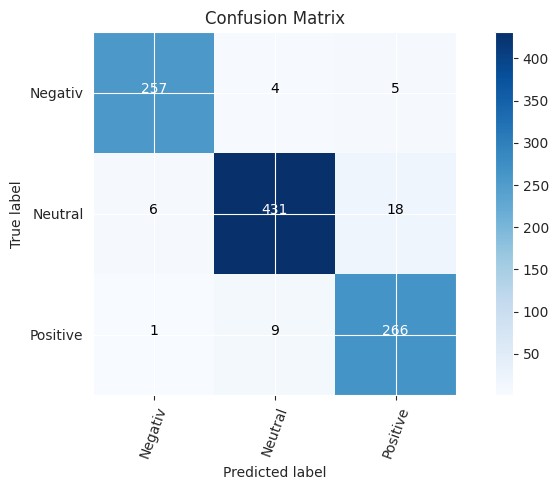

In [70]:
classes = ["Negativ", "Neutral", "Positive"]

# generate a Confusion Matrix
make_confusion_matrix(
    y_pred=y_pred, y_true=y_true, classes=classes, figsize=(8, 5), text_size=10
)

In [77]:
# print classification report
print(classification_report(y_pred=y_pred, y_true=y_true, target_names=classes))

              precision    recall  f1-score   support

     Negativ       0.97      0.97      0.97       266
     Neutral       0.97      0.95      0.96       455
    Positive       0.92      0.96      0.94       276

    accuracy                           0.96       997
   macro avg       0.95      0.96      0.96       997
weighted avg       0.96      0.96      0.96       997



In [83]:
# sample texts needs tokenizing before prediction
def tokenize_for_pred(
    text: str, max_len: int = MAX_LEN
) -> tuple[np.ndarray, np.ndarray]:
    """
    Prepares a single text string for prediction by tokenizing it into input IDs and an attention mask using a pre-defined tokenizer. 
    
    Args:
        text (str): The text to be tokenized. This should be a single string.
        max_len (int, optional): The maximum length of the tokenized output. 

    Returns:
        tuple[np.ndarray, np.ndarray]: A tuple containing two elements:
            - The first element is a NumPy array of the tokenized input IDs corresponding to the text.
            - The second element is a NumPy array of the attention mask for the input IDs. The attention mask has 1s for real tokens and 0s for padding tokens.
    """
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        return_attention_mask=True,
    )
    return np.array(encoded["input_ids"]), np.array(encoded["attention_mask"])

In [84]:
def predict_on_text(model: tf.keras.Model, text: str) -> None:
    """
    Performs a prediction using a specified model on a given text.

    Args:
        model (tf.keras.Model): The pre-trained and compiled TensorFlow model used for making predictions.
        text (str): The text string on which the prediction is to be made.

    Returns:
        None: This function does not return a value. Instead, it prints the predicted class label, the corresponding class description, and the original text.
    """
    input_ids, attention_masks = tokenize_for_pred(text=text)
    # treat like batches
    pred_prob = model.predict(
        [np.expand_dims(input_ids, axis=0), np.expand_dims(attention_masks, axis=0)]
    )
    # get right label
    pred_label = tf.argmax(pred_prob, axis=1).numpy()[0]
    # print the Prediction
    print(f"Pred: {pred_label} ({classes[pred_label]})")
    print(f"Text:\n{text}")

In [85]:
sample_text = "This Game is so amazing, i love it!"
predict_on_text(model=model, text=sample_text)

1/1 [==============================] - 0s 35ms/step
Pred: 2 (Positive)
Text:
This Game is so amazing, i love it!


In [87]:
sample_text = "I hate this, you are stupid!"
predict_on_text(model=model, text=sample_text)

1/1 [==============================] - 0s 22ms/step
Pred: 0 (Negativ)
Text:
I hate this, you are stupid!


In [94]:
sample_text = "to weather is normal today"
predict_on_text(model=model, text=sample_text)

1/1 [==============================] - 0s 23ms/step
Pred: 1 (Neutral)
Text:
to weather is normal today
